## Data Processing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import sklearn
import pypfopt
import itertools
import pypfopt
import cvxpy as cp
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.covariance import LedoitWolf

In [2]:
df = pd.read_csv('48_Industry_Portfolios_Daily_Clean.csv', index_col = 0)
df = df.rename(columns={'Average Value Weighted Returns -- Daily': 'date'})
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')
df = df.loc[(df['date'] >= '1992-12-31') & (df['date'] <= '2014-12-31')]
df = df.set_index('date')
df = df/100
df.shape

(5542, 48)

## Portfolio Seperation

In [3]:
observation_days = 250
prediction_days = 21
n_assets = df.shape[1]
n_portfolios = math.floor((len(df)-250)/21)
n_portfolios

252

In [4]:
def get_all_portfolios(obs_days, pre_days, n):
    obs_data = []
    pre_data = []
    for i in range (n):
        obs_data.append(df.iloc[pre_days*i : (obs_days+pre_days*i), :])
        pre_data.append(df.iloc[(obs_days+pre_days*i):(obs_days+pre_days*i+pre_days),:])
    return obs_data, pre_data

In [14]:
obs_group, pre_group = get_all_portfolios(observation_days,prediction_days,n_portfolios)
obs_group[0].shape

(250, 48)

In [6]:
obs_group, pre_group = get_all_portfolios(observation_days,prediction_days,n_portfolios)
print(f"number of observations:{len(obs_group)} \n number of predictions:{len(pre_group)} \n shape of observations:{obs_group[0].shape} \n shape of predictions:{pre_group[0].shape}")


number of observations:252 
 number of predictions:252 
 shape of observations:(250, 48) 
 shape of predictions:(21, 48)


## Optimization

In [7]:
def L1_norm(w, k=1):
    return k * cp.norm(w, 1)

def optimal_weights(obs_returns):
    weights = []
    expected_return = []
    volatility = []
    sharpe_ratio = []
    for i in range(len(obs_returns)):
        mu = pypfopt.expected_returns.mean_historical_return(obs_returns[i], returns_data=True,
                                                            compounding=False, frequency=250,log_returns=False)
        cov = pypfopt.risk_models.sample_cov(obs_group[i],returns_data=True,frequency=250, log_returns=False)
        cov2 = pypfopt.risk_models.CovarianceShrinkage(obs_group[i], returns_data=True, 
                                                      frequency=250, log_returns=False).ledoit_wolf(shrinkage_target='constant_correlation')
        S = 1/2 * cov + 1/2 * cov2
        ef = EfficientFrontier(mu, S, weight_bounds=(0,1))
        ef.add_objective(L1_norm, k=2)
        raw_weights = ef.min_volatility()
        cleaned_weights = ef.clean_weights()
        weights.append(np.array(list(cleaned_weights.values())))
        performance = ef.portfolio_performance(verbose=False)
        np.array(expected_return.append(performance[0]))
        np.array(volatility.append(performance[1]))
        np.array(sharpe_ratio.append(performance[2]))
    return weights, expected_return, volatility, sharpe_ratio

In [8]:
weights, expected_return, volatility, sharpe_ratio = optimal_weights(obs_group) 

In [23]:
def optimal_portfolio(optimal_weights, pre_returns):
    variance = []
    sharpe_ratio = []
    for i in range(len(pre_returns)):
        mu = pypfopt.expected_returns.mean_historical_return(pre_returns[i], returns_data=True, 
                                                compounding=False, frequency=21, log_returns=False)
        cov = pypfopt.risk_models.sample_cov(obs_group[i],returns_data=True,frequency=21, log_returns=False)
        cov2 = pypfopt.risk_models.CovarianceShrinkage(obs_group[i], returns_data=True, 
                                                      frequency=21, log_returns=False).ledoit_wolf(shrinkage_target='constant_correlation')
        S = 1/2 * cov + 1/2 * cov2
        sharpe_ratio.append(pypfopt.objective_functions.sharpe_ratio(optimal_weights[i], mu, S))
        variance.append(pypfopt.objective_functions.portfolio_variance(optimal_weights[i], S))
    return variance, sharpe_ratio

In [24]:
variance_pre, sharpe_ratio_pre = optimal_portfolio(weights, pre_group)

## LCC2 Portfolio variances of FF48

In [25]:
var = np.sum(variance_pre)/len(variance_pre)
var #0.00115

0.0010919056536216863

## LCC2 Out-of-sample Sharpe ratio of FF48

In [26]:
sharpe_ratio_ = np.sum(sharpe_ratio_pre)/len(sharpe_ratio_pre)
sharpe_ratio_ #0.3106

0.4310926570146852

# Plot

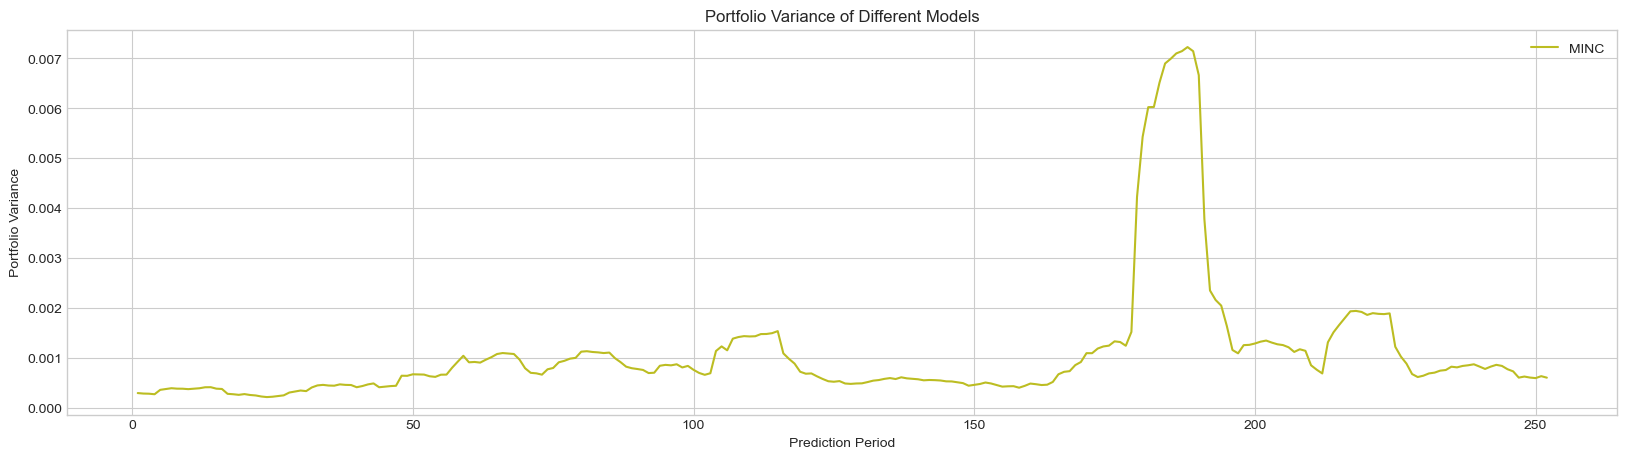

In [27]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(20,5))
plt.title('Portfolio Variance of Different Models')
plt.xlabel('Prediction Period') 
plt.ylabel('Portfolio Variance') 
plt.plot(list(np.arange(1,253,1)), variance_pre, color='tab:olive', label='MINC')
# plt.plot(list(np.arange(1,253,1)), Upper_bound_variance_pre, color='tab:brown')
plt.legend(loc='upper right')

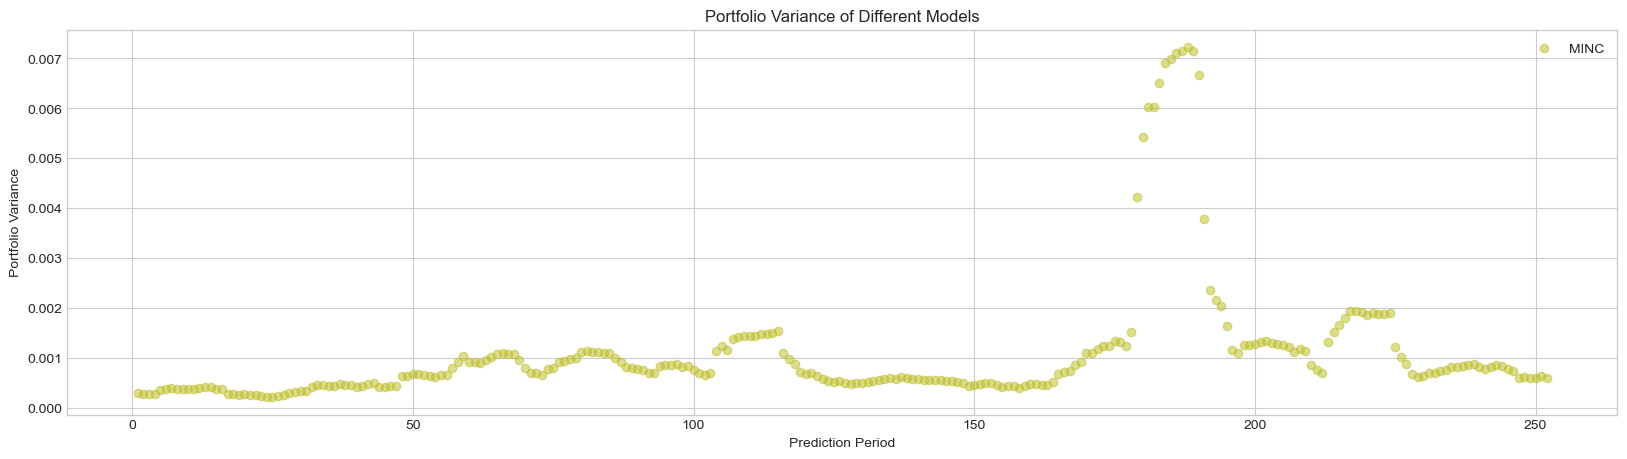

In [28]:
plt.figure(figsize=(20,5))
plt.title('Portfolio Variance of Different Models')
plt.xlabel('Prediction Period') 
plt.ylabel('Portfolio Variance') 
plt.scatter(list(np.arange(1,253,1)), variance_pre, color='tab:olive', label='MINC', alpha=0.5)
# plt.plot(list(np.arange(1,253,1)), Upper_bound_variance_pre, color='tab:brown')
plt.legend(loc='upper right')